In [1]:
from portfolio_tester.config import Asset, Portfolio, SamplerConfig, SimConfig, Goal
from portfolio_tester.data.fetchers import fetch_prices_monthly, prep_returns_and_macro, fetch_fred_series
from portfolio_tester.sampling.bootstrap import ReturnSampler
from portfolio_tester.engine.simulator import MonteCarloSimulator
from portfolio_tester.analytics.metrics import cagr, twrr_annualized, max_drawdown
import numpy as np

In [2]:
# 1) Portfolio (MVP)
p = Portfolio([
    Asset("VTI","Vanguard Total Stock Market ETF",0.30),
    Asset("TLT","iShares 20+ Year Treasury Bond ETF",0.40),
    Asset("IEF","iShares 7-10 Year Treasury Bond ETF",0.15),
    Asset("GSG","iShares S&P GSCI Commodity-Indexed Trust",0.075),
    Asset("GLD","SPDR Gold Shares",0.075),
])


In [3]:

# 2) Configs
sim_cfg = SimConfig(horizon_months=30*12, n_sims=100, rebalance_every_months=1, starting_balance=1_000_000)  # start with 100 sims
sam_cfg = SamplerConfig(mode="single_year", block_years=1, seed=42)

goals = [
    # Withdraw $4,000/mo starting in 1 year, for 30 years, inflation-indexed (real)
    Goal("Retirement Withdrawals", amount=-4000, start_month=12, frequency=12, repeats=30*12, real=True),
]


In [4]:
# 3) Data
tickers = p.tickers()
prices_m = fetch_prices_monthly(tickers)
rets_m, infl_m, rf_m = prep_returns_and_macro(prices_m)



In [5]:
# 4) Sample paths
sampler = ReturnSampler(rets_m, infl_m)
R_paths, CPI_paths = sampler.sample(sim_cfg.horizon_months, sim_cfg.n_sims, sam_cfg)

In [6]:
# 5) Run simulation
sim = MonteCarloSimulator(weights=p.weights_vector(), starting_balance=sim_cfg.starting_balance, rebalance_every_months=sim_cfg.rebalance_every_months)
out = sim.run_with_cashflows(R_paths, CPI_paths, goals)

In [7]:
# 6) Simple summary
surv = (out["failure_month"] == -1).mean()
cagr_vals = cagr(out["balances"], sim_cfg.horizon_months)
twrr_vals = twrr_annualized(out["twrr_monthly"])
mdd_vals = max_drawdown(out["balances"])

def pct(x): return f"{100*x:.1f}%"
print("=== Monte Carlo Summary (100 sims) ===")
print(f"Survival rate: {pct(surv)}")
print(f"End balance (nominal) median: ${np.median(out['balances'][:,-1]):,.0f}")
print(f"CAGR median: {np.nanmedian(cagr_vals):.2%}")
print(f"TWRR median: {np.nanmedian(twrr_vals):.2%}")
print(f"Max Drawdown median: {np.median(mdd_vals):.1%}")
print("Percentiles (10/50/90) - End Balance:",
        [f"${v:,.0f}" for v in np.percentile(out['balances'][:,-1], [10,50,90])])

=== Monte Carlo Summary (100 sims) ===
Survival rate: 64.0%
End balance (nominal) median: $479,657
CAGR median: -2.42%
TWRR median: 5.45%
Max Drawdown median: -67.8%
Percentiles (10/50/90) - End Balance: ['$0', '$479,657', '$3,164,611']


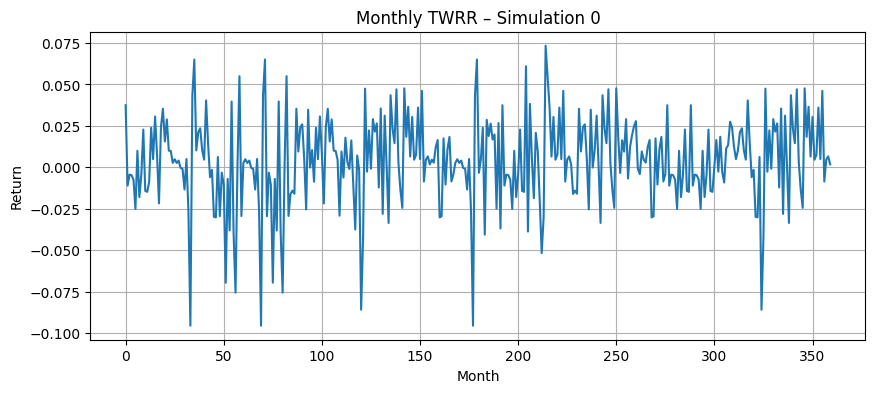

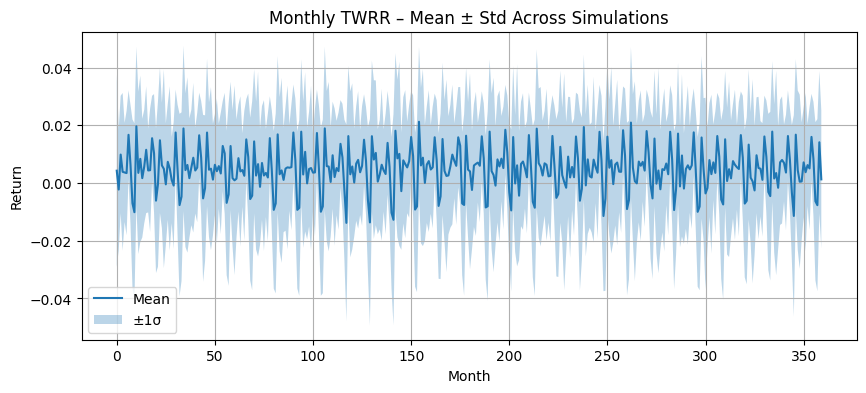

In [8]:


import numpy as np
import matplotlib.pyplot as plt

twrr = out["twrr_monthly"]  # shape: (n_sims, T)

# 1) Plot a single simulation’s path
plt.figure(figsize=(10, 4))
plt.plot(twrr[1])
plt.title("Monthly TWRR – Simulation 0")
plt.xlabel("Month")
plt.ylabel("Return")
plt.grid(True)
plt.show()

# 2) Optionally add the mean ±1 std band over all simulations
mean = twrr.mean(axis=0)
std = twrr.std(axis=0)
months = np.arange(twrr.shape[1])

plt.figure(figsize=(10, 4))
plt.plot(months, mean, label="Mean")
plt.fill_between(months, mean - std, mean + std, alpha=0.3, label="±1σ")
plt.title("Monthly TWRR – Mean ± Std Across Simulations")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()




In [9]:
mdd_vals

array([-0.68802024, -1.        , -0.28301879, -1.        , -0.66778873,
       -1.        , -1.        , -0.31385802, -0.3929748 , -0.74793115,
       -0.24805754, -0.53379942, -1.        , -0.24543475, -0.26764902,
       -1.        , -0.4695362 , -1.        , -0.37369523, -1.        ,
       -1.        , -0.51207609, -0.45607313, -0.19278579, -1.        ,
       -0.78121984, -1.        , -1.        , -0.70669624, -0.85433198,
       -0.5915496 , -0.32200228, -0.54841058, -1.        , -1.        ,
       -0.24751564, -1.        , -0.97918795, -1.        , -0.1530497 ,
       -1.        , -1.        , -0.23832144, -0.40421848, -1.        ,
       -1.        , -0.38198995, -0.35872323, -0.42666749, -0.36201366,
       -0.36721888, -0.85565951, -0.29417597, -0.26161078, -0.42729229,
       -1.        , -0.26421625, -1.        , -0.34047253, -0.35556129,
       -1.        , -0.91213101, -1.        , -1.        , -1.        ,
       -1.        , -0.65576221, -0.74429294, -0.12756226, -0.40

In [10]:
out["alloc"]


array([[1.33139798e+05, 1.77519731e+05, 6.65698990e+04, 3.32849495e+04,
        3.32849495e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [5.97666757e+05, 7.96889009e+05, 2.98833378e+05, 1.49416689e+05,
        1.49416689e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.38460961e+05, 1.84614615e+05, 6.92304807e+04, 3.46152403e+04,
        3.46152403e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [6.16542392e+05, 8.22056523e+05, 3.08271196e+05, 1.54135598e+05,
        1.54135598e+05],
       [1.95220407e+05, 2.60293876e+05, 9.76102037e+04, 4.88051018e+04,
        4.88051018e+04],
       [9.30498554e+04, 1.24066474e+05, 4.65249277e+04, 2.32624638e+04,
        2.32624638e+04],
       [4.36248226e+05, 5.8166

In [11]:
denom = out["alloc"].sum(axis=1, keepdims=True)
out["alloc_ratio"] = out["alloc"] / denom


/var/folders/ll/492zxwjn2_g12hz3hf2f0l5h0000gn/T/ipykernel_13286/1144277843.py:2: RuntimeWarning: invalid value encountered in divide
  out["alloc_ratio"] = out["alloc"] / denom


In [12]:
out["alloc_ratio"]

array([[0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [  nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan],
       [0.3  , 0.4  , 0.15 , 0.075, 0.075],
       [0.3  , 0.4  , 0.15 , 0.0